<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Movie recommender with multinomial RBM (Tensorflow, GPU)

A Restricted Boltzmann Machine (RBM) is a generative neural network model typically used to perform unsupervised learning. The main task of an RBM is to learn the joint probability distribution $P(v,h)$, where $v$ are the visible units and $h$ the hidden ones. The hidden units represent latent variables while the visible units are clamped on the input data. Once the joint distribution is learnt, new examples are generated by sampling from it.  

In this notebook, we provide an example of how to utilize the RBM to perform user/item recommendations. In particular, we use as a case study the [movielens dataset](https://movielens.org), comprising user's ranking of movies on a scale of 1 to 5. 

This notebook provides a quick start, showing the basic steps needed to use and evaluate the algorithm. A detailed discussion of the RBM model together with a deeper analysis of the recommendation task is provided in the [RBM Deep Dive section](../02_model/rbm_deep_dive.ipynb). The RBM implementation presented here is based on the article by Ruslan Salakhutdinov, Andriy Mnih and Geoffrey Hinton [Restricted Boltzmann Machines for Collaborative Filtering](https://www.cs.toronto.edu/~rsalakhu/papers/rbmcf.pdf) with the exception that here we use multinomial units instead of the one-hot encoded used in the paper.  

### Advantages of RBM: 

The model generates ratings for a user/movie pair using a collaborative filtering based approach. While matrix factorization methods learn how to reproduce an instance of the user/item affinity matrix, the RBM learns the underlying probability distribution. This has several advantages: 

- Generalizability : the model generalize well to new examples.
- Stability in time: if the recommendation task is time-stationary, the model does not need to be trained often to accomodate new ratings/users. 
- The tensorflow implementation presented here allows fast training on GPU 

## 0 Global Settings and Import

In [2]:
# set the environment path to find Recommenders
import sys

import pandas as pd
import scrapbook as sb
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.datasets import movielens
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.utils.plot import line_graph

#For interactive mode only
%load_ext autoreload
%autoreload 2
%matplotlib inline

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
Pandas version: 1.3.5
Tensorflow version: 2.7.0


# 1 Load Data 

Here we select the size of the movielens dataset. In this example we consider the 100k ratings datasets, provided by  943 users on 1682 movies. The data are imported in a pandas dataframe including the user ID, the item ID, the ratings and a timestamp denoting when a particular user rated a particular item.  

In [3]:
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

In [4]:
data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=['userID','movieID','rating','timestamp']
)

data.head()

100%|██████████| 4.81k/4.81k [00:00<00:00, 31.7kKB/s]


,userID,movieID,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


### 1.2 Split the data using the stratified splitter  

As a second step we generate the user/item affiity matrix and then split the data into train and test set. If you are familiar with training supervised learning model, here you will notice the first difference. In the former case, we cut off a certain proportion of training examples from dataset (e.g. images), here corresponding to users (or items), ending up with two matrices (train and test) having different row dimensions. Here we need to mantain the same matrix size for the train and test set, but the two will contain different amounts of ratings, see the [deep dive notebook](../02_model/rbm_deep_dive.ipynb) for more details. The affinity matrix reads     

In [5]:
#to use standard names across the analysis 
header = {
        "col_user": "userID",
        "col_item": "movieID",
        "col_rating": "rating",
    }

#instantiate the sparse matrix generation  
am = AffinityMatrix(df = data, **header)

#obtain the sparse matrix 
X, _, _ = am.gen_affinity_matrix()

The method also returns informations on the sparsness of the dataset and the size of the user/affinity matrix. The former is given by the ratio between the unrated elements and the total number of matrix elements. This is what makes a recommendation task hard: we try to predict 93% of the missing data with only 7% of information!

We split the matrix using the default ration of 0.75, i.e. 75% of the ratings will constitute the train set.

In [6]:
Xtr, Xtst = numpy_stratified_split(X)

The splitter returns:

- Xtr: a matrix containing the train set ratings 
- Xtst: a matrix containing the test elements 

Note that the train/test matrices have exactly the same dimension, but different entries as it can be explicitly verified:

In [7]:
print('train matrix size', Xtr.shape)
print('test matrix size', Xtst.shape)

train matrix size (943, 1682)
test matrix size (943, 1682)


## 2 Train the RBM model

The model has been implemented as a Tensorflow (TF) class. TF does not support probabilistic models natively, so the implementation of the algorithm has a different structure than the one you may be used to see in popular supervised models. The class has been implemented in such a way that the TF session is hidden inside the `fit()` method and no explicit call is needed. The algorithm operates in three different steps: 

- Model initialization: This is where we tell TF how to build the computational graph. The main parameters to specify are the number of hidden units, the number of training epochs and the minibatch size. Other parameters can be optionally tweaked for experimentation and to achieve better performance, as explained in the [RBM Deep Dive section](../02_model/rbm_deep_dive.ipynb).

- Model fit: This is where we train the model on the data. The method takes two arguments: the training and test set matrices. Note that the model is trained **only** on the training set, the test set is used to display the generalization accuracy of the trained model, useful to have an idea of how to fix the hyper parameters. 

- Model prediction: This is where we generate ratings for the unseen items. Once the model has been trained and we are satisfied with its overall accuracy, we sample new ratings from the learned distribution. In particular, we extract the top_k (e.g. 10) most relevant recommendations according to some predefined score. The prediction is then returned in a dataframe format ready to be analysed and deployed.  

In [8]:
#First we initialize the model class
model = RBM(hidden_units= 600, training_epoch = 30, minibatch_size= 60, keep_prob=0.9,with_metrics =True)

Note that the first time the fit method is called it may take longer to return the result. This is due to the fact that TF needs to initialized the GPU session. You will notice that this is not the case when training the algorithm the second or more times.   

Took 4.16 seconds for training.


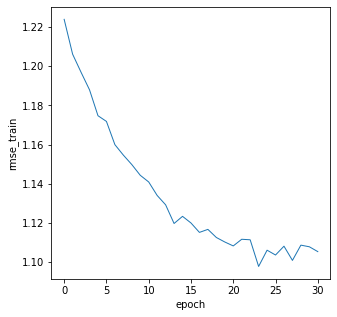

In [9]:
# Model Fit
with Timer() as train_time:
    model.fit(Xtr, Xtst)

print("Took {:.2f} seconds for training.".format(train_time.interval))

# Plot the train RMSE as a function of the epochs
line_graph(values=model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')

During training, we can optionlly evauate the root mean squared error to have an idea of how the learning is proceeding. We would generally like to see this quantity decreasing as a function of the learning epochs. To visualise this choose `with_metrics = True` in the `RBM()` model function. 

Once the model has been trained, we can predict new ratings on the test set.

In [10]:
# number of top score elements to be recommended  
K = 10

# Model prediction on the test set Xtst.
with Timer() as prediction_time:
    top_k =  model.recommend_k_items(Xtst)

print("Took {:.2f} seconds for prediction.".format(prediction_time.interval))

Took 0.23 seconds for prediction.


`top_k` returns the first K elements having the highest recommendation score. Here the recommendation score is evaluated by multiplying the predicted rating by its probability, i.e. the confidence the algorithm has about its output. So if we have two items both with predicted ratings 5, but one with probability 0.5 and the other 0.9, the latter will be considered more relevant. In order to inspect the prediction and use the evaluation metrics in this repository, we convert both top_k and Xtst to pandas dataframe format:

In [11]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

In [12]:
top_k_df.head(10)

,userID,movieID,prediction
0,1,100,4.514472
1,1,65,4.776741
2,1,82,4.832035
3,1,64,4.538263
4,1,1104,4.899394
5,1,1261,4.587405
6,1,1351,4.588839
7,1,1515,4.524197
8,1,1521,4.608923
9,1,1546,4.876138


## 4 Evaluation metrics 

Here we evaluate the performance of the algorithm using the metrics provided in the `PythonRankingEvaluation` class. Note that the following metrics take into account only the first K elements, therefore their value may be different from the one displayed from the `model.fit()` method. 

In [13]:
def ranking_metrics(
    data_size,
    data_true,
    data_pred,
    K
):

    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)

    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                      col_rating="rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)

    eval_precision = precision_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)

    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="movieID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)

    
    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP": eval_map,
            "nDCG@k": eval_ndcg,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
        }, 
        index=[0]
    )
    
    return df_result

In [14]:
eval_100k = ranking_metrics(
    data_size="mv 100k",
    data_true=test_df,
    data_pred=top_k_df,
    K=10
)

eval_100k

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,mv 100k,10,0.143166,0.412123,0.335525,0.212234


In [15]:
# Record results with papermill for tests
sb.glue("map", eval_100k['MAP'][0])
sb.glue("ndcg", eval_100k['nDCG@k'][0])
sb.glue("precision", eval_100k['Precision@k'][0])
sb.glue("recall", eval_100k['Recall@k'][0])